In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import clip
from torch.nn import functional as F
import torch.nn as nn
from torchvision import transforms
from PIL import Image
train = False
classes = None
pictures= None

def load_data():
    data_list = []
    label_list = []
    texts = []
    images = []
    
    if train:
        text_directory = "/home/ldy/Workspace/THINGS/images_set/training_images"  
    else:
        text_directory = "/home/ldy/Workspace/THINGS/images_set/test_images"

    dirnames = [d for d in os.listdir(text_directory) if os.path.isdir(os.path.join(text_directory, d))]
    dirnames.sort()
    
    if classes is not None:
        dirnames = [dirnames[i] for i in classes]

    for dir in dirnames:

        try:
            idx = dir.index('_')
            description = dir[idx+1:]
        except ValueError:
            print(f"Skipped: {dir} due to no '_' found.")
            continue
            
        new_description = f"{description}"
        texts.append(new_description)

    if train:
        img_directory = "/home/ldy/Workspace/THINGS/images_set/training_images"
    else:
        img_directory ="/home/ldy/Workspace/THINGS/images_set/test_images"
    
    all_folders = [d for d in os.listdir(img_directory) if os.path.isdir(os.path.join(img_directory, d))]
    all_folders.sort()

    if classes is not None and pictures is not None:
        images = []
        for i in range(len(classes)):
            class_idx = classes[i]
            pic_idx = pictures[i]
            if class_idx < len(all_folders):
                folder = all_folders[class_idx]
                folder_path = os.path.join(img_directory, folder)
                all_images = [img for img in os.listdir(folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
                all_images.sort()
                if pic_idx < len(all_images):
                    images.append(os.path.join(folder_path, all_images[pic_idx]))
    elif classes is not None and pictures is None:
        images = []
        for i in range(len(classes)):
            class_idx = classes[i]
            if class_idx < len(all_folders):
                folder = all_folders[class_idx]
                folder_path = os.path.join(img_directory, folder)
                all_images = [img for img in os.listdir(folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
                all_images.sort()
                images.extend(os.path.join(folder_path, img) for img in all_images)
    elif classes is None:
        images = []
        for folder in all_folders:
            folder_path = os.path.join(img_directory, folder)
            all_images = [img for img in os.listdir(folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
            all_images.sort()  
            images.extend(os.path.join(folder_path, img) for img in all_images)
    else:

        print("Error")
    return texts, images
texts, images = load_data()
# images

In [2]:
texts

['aircraft_carrier',
 'antelope',
 'backscratcher',
 'balance_beam',
 'banana',
 'baseball_bat',
 'basil',
 'basketball',
 'bassoon',
 'baton4',
 'batter',
 'beaver',
 'bench',
 'bike',
 'birthday_cake',
 'blowtorch',
 'boat',
 'bok_choy',
 'bonnet',
 'bottle_opener',
 'brace',
 'bread',
 'breadbox',
 'bug',
 'buggy',
 'bullet',
 'bun',
 'bush',
 'calamari',
 'candlestick',
 'cart',
 'cashew',
 'cat',
 'caterpillar',
 'cd_player',
 'chain',
 'chaps',
 'cheese',
 'cheetah',
 'chest2',
 'chime',
 'chopsticks',
 'cleat',
 'cleaver',
 'coat',
 'cobra',
 'coconut',
 'coffee_bean',
 'coffeemaker',
 'cookie',
 'cordon_bleu',
 'coverall',
 'crab',
 'creme_brulee',
 'crepe',
 'crib',
 'croissant',
 'crow',
 'cruise_ship',
 'crumb',
 'cupcake',
 'dagger',
 'dalmatian',
 'dessert',
 'dragonfly',
 'dreidel',
 'drum',
 'duffel_bag',
 'eagle',
 'eel',
 'egg',
 'elephant',
 'espresso',
 'face_mask',
 'ferry',
 'flamingo',
 'folder',
 'fork',
 'freezer',
 'french_horn',
 'fruit',
 'garlic',
 'glove',


In [3]:
import os

import torch
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
# os.environ['http_proxy'] = 'http://10.16.35.10:13390' 
# os.environ['https_proxy'] = 'http://10.16.35.10:13390' 

os.environ["WANDB_API_KEY"] = "KEY"
os.environ["WANDB_MODE"] = 'offline'
from itertools import combinations

import clip
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import tqdm
from eegdatasets_leaveone import EEGDataset
from eegencoder import eeg_encoder
from einops.layers.torch import Rearrange, Reduce
from lavis.models.clip_models.loss import ClipLoss
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, Dataset
import random
from utils import wandb_logger
from torch import Tensor
import math
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, d_model + 1, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term[:d_model // 2 + 1])
        pe[:, 1::2] = torch.cos(position * div_term[:d_model // 2])

        self.register_buffer('pe', pe)

    def forward(self, x):
        pe = self.pe[:x.size(0), :].unsqueeze(1).repeat(1, x.size(1), 1)
        x = x + pe
        return x




class EEGAttention(nn.Module):
    def __init__(self, channel, d_model, nhead):
        super(EEGAttention, self).__init__()
        self.pos_encoder = PositionalEncoding(d_model)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=1)
        self.channel = channel
        self.d_model = d_model

    def forward(self, src):
        src = src.permute(2, 0, 1)  # Change shape to [time_length, batch_size, channel]
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        return output.permute(1, 2, 0)  # Change shape back to [batch_size, channel, time_length]
class PatchEmbedding(nn.Module):
    def __init__(self, emb_size=40):
        super().__init__()
        # revised from shallownet
        self.tsconv = nn.Sequential(
            nn.Conv2d(1, 40, (1, 5), (1, 1)),
            nn.AvgPool2d((1, 17), (1, 5)),
            nn.BatchNorm2d(40),
            nn.ELU(),
            nn.Conv2d(40, 40, (63, 1), (1, 1)),
            nn.BatchNorm2d(40),
            nn.ELU(),
            nn.Dropout(0.5),
        )

        self.projection = nn.Sequential(
            nn.Conv2d(40, emb_size, (1, 1), stride=(1, 1)),  
            Rearrange('b e (h) (w) -> b (h w) e'),
        )

    def forward(self, x: Tensor) -> Tensor:
        # b, _, _, _ = x.shape
        x = x.unsqueeze(1)     
        # print("x", x.shape)   
        x = self.tsconv(x)
        # print("tsconv", x.shape)   
        x = self.projection(x)
        # print("projection", x.shape)  
        return x


class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x


class FlattenHead(nn.Sequential):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x = x.contiguous().view(x.size(0), -1)
        return x


class Enc_eeg(nn.Sequential):
    def __init__(self, emb_size=40, **kwargs):
        super().__init__(
            PatchEmbedding(emb_size),
            FlattenHead()
        )

        
class Proj_eeg(nn.Sequential):
    def __init__(self, embedding_dim=1840, proj_dim=1024, drop_proj=0.5):
        super().__init__(
            nn.Linear(embedding_dim, proj_dim),
            ResidualAdd(nn.Sequential(
                nn.GELU(),
                nn.Linear(proj_dim, proj_dim),
                nn.Dropout(drop_proj),
            )),
            nn.LayerNorm(proj_dim),
        )


class Proj_img(nn.Sequential):
    def __init__(self, embedding_dim=1024, proj_dim=1024, drop_proj=0.3):
        super().__init__(
            nn.Linear(embedding_dim, proj_dim),
            ResidualAdd(nn.Sequential(
                nn.GELU(),
                nn.Linear(proj_dim, proj_dim),
                nn.Dropout(drop_proj),
            )),
            nn.LayerNorm(proj_dim),
        )
    def forward(self, x):
        return x 

class ATM_S_reconstruction_scale_0_1000(nn.Module):    
    def __init__(self, num_channels=63, sequence_length=25, num_subjects=1, num_features=64, num_latents=1024, num_blocks=1):
        super(ATM_S_reconstruction_scale_0_1000, self).__init__()
        self.attention_model = EEGAttention(num_channels, num_channels, nhead=1)   
        self.subject_wise_linear = nn.ModuleList([nn.Linear(sequence_length, sequence_length) for _ in range(num_subjects)])
        self.enc_eeg = Enc_eeg()
        self.proj_eeg = Proj_eeg()        
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))
        self.loss_func = ClipLoss()       
         
    def forward(self, x):
        x = self.attention_model(x)
        # print(f'After attention shape: {x.shape}')
         
        x = self.subject_wise_linear[0](x)
        # print(f'After subject-specific linear transformation shape: {x.shape}')
        eeg_embedding = self.enc_eeg(x)
        # print(f'After enc_eeg shape: {eeg_embedding.shape}')
        out = self.proj_eeg(eeg_embedding)
        return out  
    
    
from image_generate import *
def get_eegfeatures(sub, eegmodel, dataloader, device, text_features_all, img_features_all, k, mode):
    eegmodel.eval()
    text_features_all = text_features_all.to(device).float()
    img_features_all = img_features_all.to(device).float()
    total_loss = 0
    correct = 0
    total = 0
    alpha =0.9
    top5_correct = 0
    top5_correct_count = 0

    all_labels = set(range(text_features_all.size(0)))
    top5_acc = 0
    mse_loss_fn = nn.MSELoss()
    ridge_lambda = 0.1
    save_features = True
    features_list = []  # List to store features    
    with torch.no_grad():
        for batch_idx, (eeg_data, labels, text, text_features, img, img_features) in enumerate(dataloader):
            eeg_data = eeg_data.to(device)
            eeg_data = eeg_data[:, :, :250]
            # print("eeg_data", eeg_data.shape)
            text_features = text_features.to(device).float()
            labels = labels.to(device)
            img_features = img_features.to(device).float()
            eeg_features = eegmodel(eeg_data).float()
            features_list.append(eeg_features)
            logit_scale = eegmodel.logit_scale 
                   
            regress_loss =  mse_loss_fn(eeg_features, img_features)
            # print("eeg_features", eeg_features.shape)
            # print(torch.std(eeg_features, dim=-1))
            # print(torch.std(img_features, dim=-1))
            # l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            # loss = (regress_loss + ridge_lambda * l2_norm)       
            img_loss = eegmodel.loss_func(eeg_features, img_features, logit_scale)
            text_loss = eegmodel.loss_func(eeg_features, text_features, logit_scale)
            contrastive_loss = img_loss
            # loss = img_loss + text_loss

            regress_loss =  mse_loss_fn(eeg_features, img_features)
            # print("text_loss", text_loss)
            # print("img_loss", img_loss)
            # print("regress_loss", regress_loss)            
            # l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            # loss = (regress_loss + ridge_lambda * l2_norm)       
            loss = alpha * regress_loss *10 + (1 - alpha) * contrastive_loss*10
            # print("loss", loss)
            total_loss += loss.item()
            
            for idx, label in enumerate(labels):

                possible_classes = list(all_labels - {label.item()})
                selected_classes = random.sample(possible_classes, k-1) + [label.item()]
                selected_img_features = img_features_all[selected_classes]
                

                logits_img = logit_scale * eeg_features[idx] @ selected_img_features.T
                # logits_text = logit_scale * eeg_features[idx] @ selected_text_features.T
                # logits_single = (logits_text + logits_img) / 2.0
                logits_single = logits_img
                # print("logits_single", logits_single.shape)

                # predicted_label = selected_classes[torch.argmax(logits_single).item()]
                predicted_label = selected_classes[torch.argmax(logits_single).item()] # (n_batch, ) \in {0, 1, ..., n_cls-1}
                if predicted_label == label.item():
                    correct += 1        
                total += 1

        if save_features:
            features_tensor = torch.cat(features_list, dim=0)
            print("features_tensor", features_tensor.shape)
            torch.save(features_tensor.cpu(), f"ATM_S_eeg_features_{sub}_{mode}.pt")  # Save features as .pt file
    average_loss = total_loss / (batch_idx+1)
    accuracy = correct / total
    return average_loss, accuracy, labels, features_tensor.cpu()

from IPython.display import Image, display
config = {
"data_path": "/home/ldy/Workspace/THINGS/Preprocessed_data_250Hz",
"project": "train_pos_img_text_rep",
"entity": "sustech_rethinkingbci",
"name": "lr=3e-4_img_pos_pro_eeg",
"lr": 3e-4,
"epochs": 50,
"batch_size": 1024,
"logger": True,
"encoder_type":'ATM_S_reconstruction_scale_0_1000',
}

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

data_path = config['data_path']
emb_img_test = torch.load('variables/ViT-H-14_features_test.pt')
emb_img_train = torch.load('variables/ViT-H-14_features_train.pt')

eeg_model = ATM_S_reconstruction_scale_0_1000(63, 250)
print('number of parameters:', sum([p.numel() for p in eeg_model.parameters()]))

#####################################################################################

# eeg_model.load_state_dict(torch.load("/home/ldy/Workspace/Reconstruction/models/contrast/sub-08/01-30_00-44/40.pth"))
eeg_model.load_state_dict(torch.load("models/contrast/ATM_S_reconstruction_scale_0_1000/02-01_00-28/sub-07/40.pth"))
eeg_model = eeg_model.to(device)
sub = 'sub-07'

#####################################################################################

test_dataset = EEGDataset(data_path, subjects= [sub], train=False)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=0)
text_features_test_all = test_dataset.text_features
img_features_test_all = test_dataset.img_features
test_loss, test_accuracy,labels, eeg_features_test = get_eegfeatures(sub, eeg_model, test_loader, device, text_features_test_all, img_features_test_all,k=200, mode="test")
print(f" - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


number of parameters: 3655541
self.subjects ['sub-07']
exclude_subject None
Data tensor shape: torch.Size([200, 63, 250]), label tensor shape: torch.Size([200]), text length: 200, image length: 200
features_tensor torch.Size([200, 1024])
 - Test Loss: 8.7400, Test Accuracy: 0.3050


In [4]:
#####################################################################################
train_dataset = EEGDataset(data_path, subjects= [sub], train=True)
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=0)
text_features_test_all = train_dataset.text_features
img_features_test_all = train_dataset.img_features

train_loss, train_accuracy, labels, eeg_features_train = get_eegfeatures(sub, eeg_model, train_loader, device, text_features_test_all, img_features_test_all,k=200, mode="train")
print(f" - Test Loss: {train_loss:.4f}, Test Accuracy: {train_accuracy:.4f}")
#####################################################################################

self.subjects ['sub-07']
exclude_subject None


data_tensor torch.Size([66160, 63, 250])
Data tensor shape: torch.Size([66160, 63, 250]), label tensor shape: torch.Size([66160]), text length: 1654, image length: 16540
features_tensor torch.Size([66160, 1024])
 - Test Loss: 3.4403, Test Accuracy: 0.0044


In [5]:
emb_img_train_4 = emb_img_train.view(1654,10,1,1024).repeat(1,1,4,1).view(-1,1024)
emb_eeg = torch.load(f'/home/ldy/Workspace/Reconstruction/ATM_S_eeg_features_{sub}_train.pt')
emb_eeg_test = torch.load(f'/home/ldy/Workspace/Reconstruction/ATM_S_eeg_features_{sub}_test.pt')

In [6]:
emb_eeg.shape, emb_eeg_test.shape

(torch.Size([66160, 1024]), torch.Size([200, 1024]))

In [7]:
eeg_features_train

tensor([[ 2.4692e-01, -1.3442e-01,  1.3329e-01,  ...,  3.2141e-01,
          4.2787e-02, -4.4136e-03],
        [-3.1337e-02, -5.8582e-02, -4.7187e-02,  ..., -7.5639e-03,
          1.5037e-02,  2.7694e-01],
        [-2.0007e-01,  1.3088e-01,  2.5352e-01,  ..., -3.2823e-01,
          1.9637e-01, -1.1778e-01],
        ...,
        [-4.2003e-01,  5.3887e-03,  2.1707e-01,  ..., -2.7474e-01,
         -2.6358e-04,  3.7170e-01],
        [ 2.3280e-02,  5.4719e-03,  8.1869e-02,  ..., -2.5615e-01,
          4.1716e-02, -4.3576e-02],
        [-2.2386e-01, -1.9301e-02,  1.7219e-02,  ...,  1.0063e-01,
         -3.2816e-03,  2.1525e-01]])

In [8]:
dataset = EmbeddingDataset(
    c_embeddings=eeg_features_train, h_embeddings=emb_img_train_4, 
    # h_embeds_uncond=h_embeds_imgnet
)
dl = DataLoader(dataset, batch_size=1024, shuffle=True, num_workers=64)
diffusion_prior = DiffusionPriorUNet(cond_dim=1024, dropout=0.1)
# number of parameters
print(sum(p.numel() for p in diffusion_prior.parameters() if p.requires_grad))
pipe = Pipe(diffusion_prior, device=device)

# load pretrained model
model_name = 'diffusion_prior' # 'diffusion_prior_vice_pre_imagenet' or 'diffusion_prior_vice_pre'
pipe.train(dl, num_epochs=150, learning_rate=1e-3) # to 0.142 

9675648


epoch: 0, loss: 1.1329903547580427
epoch: 1, loss: 0.9297024396749644
epoch: 2, loss: 0.7363299241432777
epoch: 3, loss: 0.5884740765278156
epoch: 4, loss: 0.4825158614378709
epoch: 5, loss: 0.40165229302186234
epoch: 6, loss: 0.34862405428519616
epoch: 7, loss: 0.3154423727439
epoch: 8, loss: 0.2969600815039415
epoch: 9, loss: 0.2789288131090311
epoch: 10, loss: 0.2668823003768921
epoch: 11, loss: 0.25595678710020503
epoch: 12, loss: 0.24354626398820142
epoch: 13, loss: 0.2338226196857599
epoch: 14, loss: 0.22498145126379454
epoch: 15, loss: 0.2174298536318999
epoch: 16, loss: 0.21257303930245913
epoch: 17, loss: 0.20575957412903126
epoch: 18, loss: 0.20133435886639814
epoch: 19, loss: 0.1985116394666525
epoch: 20, loss: 0.19465419558378366
epoch: 21, loss: 0.19071433177361122
epoch: 22, loss: 0.1868108352789512
epoch: 23, loss: 0.1855131316643495
epoch: 24, loss: 0.18509330520263084
epoch: 25, loss: 0.19170151765529925
epoch: 26, loss: 0.19592685676538027
epoch: 27, loss: 0.193758095

In [9]:

# pipe.diffusion_prior.load_state_dict(torch.load(f'./fintune_ckpts/{config['data_path']}/{sub}/{model_name}.pt', map_location=device))
save_path = f'./fintune_ckpts/{config["encoder_type"]}/{sub}/{model_name}.pt'

directory = os.path.dirname(save_path)

# Create the directory if it doesn't exist
os.makedirs(directory, exist_ok=True)
torch.save(pipe.diffusion_prior.state_dict(), save_path)
from PIL import Image
import os

# Assuming generator.generate returns a PIL Image
generator = Generator4Embeds(num_inference_steps=4, device=device)

directory = f"generated_imgs/{sub}"
for k in range(200):
    eeg_embeds = emb_eeg_test[k:k+1]
    h = pipe.generate(c_embeds=eeg_embeds, num_inference_steps=50, guidance_scale=5.0)
    for j in range(10):
        image = generator.generate(h.to(dtype=torch.float16))
        # Construct the save path for each image
        path = f'{directory}/{texts[k]}/{j}.png'
        # Ensure the directory exists
        os.makedirs(os.path.dirname(path), exist_ok=True)
        # Save the PIL Image
        image.save(path)
        print(f'Image saved to {path}')

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

50it [00:00, 249.98it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/aircraft_carrier/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/aircraft_carrier/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/aircraft_carrier/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/aircraft_carrier/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/aircraft_carrier/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/aircraft_carrier/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/aircraft_carrier/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/aircraft_carrier/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/aircraft_carrier/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/aircraft_carrier/9.png


50it [00:00, 244.70it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/antelope/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/antelope/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/antelope/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/antelope/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/antelope/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/antelope/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/antelope/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/antelope/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/antelope/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/antelope/9.png


50it [00:00, 228.21it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/backscratcher/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/backscratcher/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/backscratcher/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/backscratcher/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/backscratcher/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/backscratcher/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/backscratcher/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/backscratcher/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/backscratcher/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/backscratcher/9.png


50it [00:00, 233.23it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/balance_beam/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/balance_beam/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/balance_beam/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/balance_beam/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/balance_beam/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/balance_beam/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/balance_beam/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/balance_beam/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/balance_beam/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/balance_beam/9.png


50it [00:00, 219.14it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/banana/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/banana/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/banana/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/banana/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/banana/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/banana/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/banana/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/banana/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/banana/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/banana/9.png


50it [00:00, 239.66it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/baseball_bat/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/baseball_bat/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/baseball_bat/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/baseball_bat/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/baseball_bat/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/baseball_bat/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/baseball_bat/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/baseball_bat/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/baseball_bat/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/baseball_bat/9.png


50it [00:00, 244.91it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/basil/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/basil/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/basil/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/basil/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/basil/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/basil/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/basil/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/basil/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/basil/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/basil/9.png


50it [00:00, 198.04it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/basketball/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/basketball/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/basketball/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/basketball/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/basketball/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/basketball/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/basketball/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/basketball/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/basketball/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/basketball/9.png


50it [00:00, 237.53it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bassoon/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bassoon/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bassoon/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bassoon/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bassoon/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bassoon/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bassoon/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bassoon/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bassoon/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bassoon/9.png


50it [00:00, 244.14it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/baton4/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/baton4/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/baton4/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/baton4/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/baton4/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/baton4/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/baton4/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/baton4/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/baton4/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/baton4/9.png


50it [00:00, 258.52it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/batter/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/batter/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/batter/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/batter/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/batter/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/batter/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/batter/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/batter/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/batter/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/batter/9.png


50it [00:00, 248.12it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/beaver/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/beaver/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/beaver/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/beaver/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/beaver/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/beaver/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/beaver/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/beaver/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/beaver/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/beaver/9.png


50it [00:00, 235.40it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bench/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bench/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bench/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bench/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bench/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bench/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bench/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bench/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bench/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bench/9.png


50it [00:00, 257.68it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bike/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bike/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bike/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bike/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bike/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bike/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bike/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bike/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bike/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bike/9.png


50it [00:00, 224.38it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/birthday_cake/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/birthday_cake/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/birthday_cake/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/birthday_cake/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/birthday_cake/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/birthday_cake/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/birthday_cake/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/birthday_cake/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/birthday_cake/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/birthday_cake/9.png


50it [00:00, 245.17it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/blowtorch/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/blowtorch/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/blowtorch/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/blowtorch/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/blowtorch/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/blowtorch/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/blowtorch/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/blowtorch/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/blowtorch/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/blowtorch/9.png


50it [00:00, 244.81it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/boat/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/boat/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/boat/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/boat/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/boat/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/boat/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/boat/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/boat/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/boat/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/boat/9.png


50it [00:00, 248.52it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bok_choy/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bok_choy/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bok_choy/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bok_choy/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bok_choy/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bok_choy/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bok_choy/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bok_choy/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bok_choy/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bok_choy/9.png


50it [00:00, 124.28it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bonnet/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bonnet/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bonnet/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bonnet/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bonnet/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bonnet/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bonnet/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bonnet/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bonnet/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bonnet/9.png


50it [00:00, 245.85it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bottle_opener/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bottle_opener/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bottle_opener/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bottle_opener/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bottle_opener/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bottle_opener/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bottle_opener/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bottle_opener/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bottle_opener/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bottle_opener/9.png


50it [00:00, 242.24it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/brace/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/brace/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/brace/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/brace/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/brace/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/brace/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/brace/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/brace/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/brace/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/brace/9.png


50it [00:00, 255.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bread/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bread/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bread/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bread/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bread/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bread/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bread/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bread/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bread/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bread/9.png


50it [00:00, 235.97it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/breadbox/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/breadbox/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/breadbox/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/breadbox/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/breadbox/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/breadbox/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/breadbox/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/breadbox/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/breadbox/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/breadbox/9.png


50it [00:00, 251.64it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bug/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bug/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bug/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bug/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bug/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bug/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bug/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bug/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bug/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bug/9.png


50it [00:00, 231.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/buggy/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/buggy/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/buggy/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/buggy/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/buggy/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/buggy/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/buggy/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/buggy/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/buggy/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/buggy/9.png


50it [00:00, 249.83it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bullet/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bullet/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bullet/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bullet/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bullet/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bullet/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bullet/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bullet/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bullet/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bullet/9.png


50it [00:00, 244.92it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bun/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bun/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bun/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bun/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bun/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bun/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bun/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bun/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bun/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bun/9.png


50it [00:00, 253.86it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bush/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bush/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bush/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bush/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bush/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bush/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bush/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bush/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bush/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/bush/9.png


50it [00:00, 247.41it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/calamari/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/calamari/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/calamari/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/calamari/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/calamari/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/calamari/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/calamari/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/calamari/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/calamari/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/calamari/9.png


50it [00:00, 256.26it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/candlestick/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/candlestick/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/candlestick/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/candlestick/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/candlestick/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/candlestick/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/candlestick/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/candlestick/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/candlestick/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/candlestick/9.png


50it [00:00, 255.80it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cart/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cart/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cart/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cart/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cart/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cart/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cart/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cart/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cart/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cart/9.png


50it [00:00, 214.47it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cashew/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cashew/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cashew/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cashew/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cashew/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cashew/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cashew/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cashew/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cashew/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cashew/9.png


50it [00:00, 252.42it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cat/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cat/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cat/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cat/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cat/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cat/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cat/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cat/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cat/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cat/9.png


50it [00:00, 246.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/caterpillar/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/caterpillar/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/caterpillar/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/caterpillar/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/caterpillar/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/caterpillar/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/caterpillar/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/caterpillar/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/caterpillar/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/caterpillar/9.png


50it [00:00, 237.49it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cd_player/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cd_player/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cd_player/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cd_player/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cd_player/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cd_player/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cd_player/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cd_player/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cd_player/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cd_player/9.png


50it [00:00, 243.55it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chain/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chain/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chain/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chain/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chain/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chain/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chain/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chain/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chain/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chain/9.png


50it [00:00, 236.76it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chaps/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chaps/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chaps/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chaps/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chaps/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chaps/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chaps/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chaps/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chaps/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chaps/9.png


50it [00:00, 243.41it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cheese/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cheese/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cheese/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cheese/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cheese/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cheese/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cheese/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cheese/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cheese/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cheese/9.png


50it [00:00, 230.72it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cheetah/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cheetah/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cheetah/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cheetah/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cheetah/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cheetah/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cheetah/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cheetah/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cheetah/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cheetah/9.png


50it [00:00, 245.25it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chest2/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chest2/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chest2/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chest2/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chest2/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chest2/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chest2/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chest2/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chest2/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chest2/9.png


50it [00:00, 250.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chime/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chime/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chime/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chime/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chime/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chime/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chime/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chime/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chime/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chime/9.png


50it [00:00, 258.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chopsticks/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chopsticks/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chopsticks/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chopsticks/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chopsticks/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chopsticks/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chopsticks/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chopsticks/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chopsticks/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/chopsticks/9.png


50it [00:00, 120.99it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cleat/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cleat/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cleat/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cleat/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cleat/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cleat/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cleat/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cleat/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cleat/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cleat/9.png


50it [00:00, 236.89it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cleaver/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cleaver/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cleaver/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cleaver/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cleaver/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cleaver/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cleaver/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cleaver/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cleaver/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cleaver/9.png


50it [00:00, 247.63it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coat/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coat/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coat/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coat/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coat/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coat/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coat/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coat/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coat/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coat/9.png


50it [00:00, 245.09it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cobra/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cobra/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cobra/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cobra/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cobra/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cobra/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cobra/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cobra/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cobra/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cobra/9.png


50it [00:00, 242.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coconut/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coconut/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coconut/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coconut/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coconut/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coconut/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coconut/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coconut/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coconut/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coconut/9.png


50it [00:00, 243.64it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coffee_bean/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coffee_bean/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coffee_bean/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coffee_bean/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coffee_bean/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coffee_bean/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coffee_bean/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coffee_bean/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coffee_bean/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coffee_bean/9.png


50it [00:00, 235.68it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coffeemaker/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coffeemaker/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coffeemaker/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coffeemaker/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coffeemaker/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coffeemaker/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coffeemaker/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coffeemaker/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coffeemaker/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coffeemaker/9.png


50it [00:00, 254.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cookie/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cookie/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cookie/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cookie/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cookie/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cookie/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cookie/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cookie/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cookie/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cookie/9.png


50it [00:00, 226.62it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cordon_bleu/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cordon_bleu/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cordon_bleu/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cordon_bleu/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cordon_bleu/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cordon_bleu/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cordon_bleu/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cordon_bleu/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cordon_bleu/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cordon_bleu/9.png


50it [00:00, 252.22it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coverall/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coverall/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coverall/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coverall/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coverall/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coverall/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coverall/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coverall/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coverall/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/coverall/9.png


50it [00:00, 240.93it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crab/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crab/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crab/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crab/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crab/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crab/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crab/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crab/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crab/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crab/9.png


50it [00:00, 228.67it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/creme_brulee/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/creme_brulee/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/creme_brulee/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/creme_brulee/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/creme_brulee/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/creme_brulee/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/creme_brulee/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/creme_brulee/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/creme_brulee/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/creme_brulee/9.png


50it [00:00, 244.24it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crepe/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crepe/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crepe/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crepe/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crepe/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crepe/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crepe/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crepe/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crepe/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crepe/9.png


50it [00:00, 245.13it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crib/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crib/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crib/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crib/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crib/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crib/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crib/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crib/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crib/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crib/9.png


50it [00:00, 246.16it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/croissant/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/croissant/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/croissant/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/croissant/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/croissant/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/croissant/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/croissant/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/croissant/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/croissant/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/croissant/9.png


50it [00:00, 251.34it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crow/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crow/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crow/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crow/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crow/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crow/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crow/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crow/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crow/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crow/9.png


50it [00:00, 252.05it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cruise_ship/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cruise_ship/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cruise_ship/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cruise_ship/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cruise_ship/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cruise_ship/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cruise_ship/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cruise_ship/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cruise_ship/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cruise_ship/9.png


50it [00:00, 231.83it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crumb/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crumb/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crumb/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crumb/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crumb/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crumb/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crumb/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crumb/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crumb/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/crumb/9.png


50it [00:00, 234.59it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cupcake/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cupcake/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cupcake/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cupcake/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cupcake/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cupcake/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cupcake/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cupcake/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cupcake/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/cupcake/9.png


50it [00:00, 225.89it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dagger/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dagger/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dagger/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dagger/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dagger/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dagger/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dagger/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dagger/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dagger/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dagger/9.png


50it [00:00, 227.72it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dalmatian/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dalmatian/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dalmatian/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dalmatian/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dalmatian/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dalmatian/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dalmatian/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dalmatian/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dalmatian/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dalmatian/9.png


50it [00:00, 237.65it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dessert/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dessert/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dessert/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dessert/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dessert/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dessert/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dessert/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dessert/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dessert/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dessert/9.png


50it [00:00, 201.85it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dragonfly/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dragonfly/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dragonfly/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dragonfly/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dragonfly/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dragonfly/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dragonfly/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dragonfly/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dragonfly/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dragonfly/9.png


50it [00:00, 227.32it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dreidel/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dreidel/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dreidel/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dreidel/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dreidel/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dreidel/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dreidel/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dreidel/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dreidel/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/dreidel/9.png


50it [00:00, 238.76it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/drum/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/drum/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/drum/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/drum/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/drum/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/drum/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/drum/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/drum/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/drum/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/drum/9.png


50it [00:00, 118.09it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/duffel_bag/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/duffel_bag/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/duffel_bag/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/duffel_bag/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/duffel_bag/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/duffel_bag/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/duffel_bag/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/duffel_bag/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/duffel_bag/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/duffel_bag/9.png


50it [00:00, 254.13it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/eagle/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/eagle/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/eagle/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/eagle/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/eagle/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/eagle/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/eagle/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/eagle/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/eagle/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/eagle/9.png


50it [00:00, 250.25it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/eel/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/eel/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/eel/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/eel/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/eel/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/eel/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/eel/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/eel/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/eel/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/eel/9.png


50it [00:00, 254.07it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/egg/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/egg/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/egg/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/egg/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/egg/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/egg/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/egg/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/egg/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/egg/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/egg/9.png


50it [00:00, 238.60it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/elephant/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/elephant/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/elephant/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/elephant/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/elephant/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/elephant/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/elephant/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/elephant/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/elephant/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/elephant/9.png


50it [00:00, 245.99it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/espresso/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/espresso/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/espresso/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/espresso/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/espresso/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/espresso/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/espresso/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/espresso/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/espresso/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/espresso/9.png


50it [00:00, 254.54it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/face_mask/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/face_mask/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/face_mask/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/face_mask/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/face_mask/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/face_mask/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/face_mask/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/face_mask/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/face_mask/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/face_mask/9.png


50it [00:00, 242.17it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ferry/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ferry/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ferry/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ferry/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ferry/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ferry/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ferry/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ferry/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ferry/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ferry/9.png


50it [00:00, 234.27it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/flamingo/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/flamingo/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/flamingo/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/flamingo/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/flamingo/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/flamingo/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/flamingo/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/flamingo/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/flamingo/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/flamingo/9.png


50it [00:00, 237.29it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/folder/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/folder/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/folder/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/folder/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/folder/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/folder/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/folder/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/folder/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/folder/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/folder/9.png


50it [00:00, 248.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/fork/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/fork/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/fork/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/fork/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/fork/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/fork/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/fork/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/fork/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/fork/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/fork/9.png


50it [00:00, 247.43it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/freezer/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/freezer/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/freezer/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/freezer/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/freezer/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/freezer/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/freezer/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/freezer/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/freezer/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/freezer/9.png


50it [00:00, 251.67it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/french_horn/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/french_horn/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/french_horn/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/french_horn/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/french_horn/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/french_horn/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/french_horn/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/french_horn/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/french_horn/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/french_horn/9.png


50it [00:00, 243.52it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/fruit/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/fruit/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/fruit/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/fruit/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/fruit/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/fruit/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/fruit/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/fruit/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/fruit/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/fruit/9.png


50it [00:00, 240.21it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/garlic/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/garlic/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/garlic/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/garlic/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/garlic/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/garlic/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/garlic/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/garlic/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/garlic/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/garlic/9.png


50it [00:00, 255.85it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/glove/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/glove/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/glove/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/glove/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/glove/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/glove/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/glove/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/glove/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/glove/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/glove/9.png


50it [00:00, 255.50it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/golf_cart/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/golf_cart/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/golf_cart/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/golf_cart/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/golf_cart/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/golf_cart/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/golf_cart/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/golf_cart/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/golf_cart/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/golf_cart/9.png


50it [00:00, 245.89it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/gondola/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/gondola/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/gondola/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/gondola/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/gondola/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/gondola/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/gondola/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/gondola/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/gondola/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/gondola/9.png


50it [00:00, 244.82it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/goose/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/goose/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/goose/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/goose/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/goose/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/goose/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/goose/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/goose/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/goose/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/goose/9.png


50it [00:00, 251.36it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/gopher/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/gopher/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/gopher/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/gopher/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/gopher/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/gopher/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/gopher/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/gopher/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/gopher/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/gopher/9.png


50it [00:00, 216.00it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/gorilla/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/gorilla/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/gorilla/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/gorilla/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/gorilla/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/gorilla/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/gorilla/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/gorilla/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/gorilla/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/gorilla/9.png


50it [00:00, 237.59it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/grasshopper/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/grasshopper/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/grasshopper/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/grasshopper/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/grasshopper/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/grasshopper/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/grasshopper/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/grasshopper/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/grasshopper/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/grasshopper/9.png


50it [00:00, 242.80it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/grenade/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/grenade/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/grenade/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/grenade/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/grenade/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/grenade/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/grenade/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/grenade/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/grenade/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/grenade/9.png


50it [00:00, 248.78it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/hamburger/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/hamburger/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/hamburger/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/hamburger/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/hamburger/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/hamburger/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/hamburger/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/hamburger/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/hamburger/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/hamburger/9.png


50it [00:00, 242.24it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/hammer/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/hammer/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/hammer/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/hammer/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/hammer/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/hammer/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/hammer/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/hammer/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/hammer/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/hammer/9.png


50it [00:00, 240.18it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/handbrake/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/handbrake/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/handbrake/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/handbrake/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/handbrake/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/handbrake/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/handbrake/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/handbrake/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/handbrake/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/handbrake/9.png


50it [00:00, 109.87it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/headscarf/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/headscarf/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/headscarf/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/headscarf/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/headscarf/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/headscarf/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/headscarf/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/headscarf/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/headscarf/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/headscarf/9.png


50it [00:00, 234.37it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/highchair/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/highchair/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/highchair/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/highchair/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/highchair/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/highchair/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/highchair/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/highchair/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/highchair/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/highchair/9.png


50it [00:00, 250.39it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/hoodie/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/hoodie/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/hoodie/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/hoodie/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/hoodie/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/hoodie/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/hoodie/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/hoodie/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/hoodie/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/hoodie/9.png


50it [00:00, 216.33it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/hummingbird/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/hummingbird/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/hummingbird/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/hummingbird/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/hummingbird/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/hummingbird/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/hummingbird/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/hummingbird/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/hummingbird/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/hummingbird/9.png


50it [00:00, 235.93it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ice_cube/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ice_cube/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ice_cube/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ice_cube/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ice_cube/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ice_cube/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ice_cube/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ice_cube/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ice_cube/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ice_cube/9.png


50it [00:00, 257.14it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ice_pack/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ice_pack/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ice_pack/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ice_pack/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ice_pack/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ice_pack/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ice_pack/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ice_pack/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ice_pack/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ice_pack/9.png


50it [00:00, 237.18it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/jeep/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/jeep/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/jeep/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/jeep/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/jeep/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/jeep/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/jeep/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/jeep/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/jeep/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/jeep/9.png


50it [00:00, 237.24it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/jelly_bean/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/jelly_bean/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/jelly_bean/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/jelly_bean/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/jelly_bean/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/jelly_bean/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/jelly_bean/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/jelly_bean/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/jelly_bean/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/jelly_bean/9.png


50it [00:00, 223.16it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/jukebox/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/jukebox/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/jukebox/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/jukebox/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/jukebox/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/jukebox/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/jukebox/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/jukebox/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/jukebox/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/jukebox/9.png


50it [00:00, 232.52it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/kettle/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/kettle/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/kettle/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/kettle/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/kettle/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/kettle/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/kettle/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/kettle/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/kettle/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/kettle/9.png


50it [00:00, 243.96it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/kneepad/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/kneepad/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/kneepad/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/kneepad/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/kneepad/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/kneepad/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/kneepad/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/kneepad/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/kneepad/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/kneepad/9.png


50it [00:00, 248.35it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ladle/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ladle/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ladle/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ladle/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ladle/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ladle/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ladle/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ladle/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ladle/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ladle/9.png


50it [00:00, 250.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/lamb/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/lamb/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/lamb/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/lamb/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/lamb/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/lamb/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/lamb/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/lamb/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/lamb/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/lamb/9.png


50it [00:00, 208.81it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/lampshade/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/lampshade/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/lampshade/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/lampshade/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/lampshade/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/lampshade/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/lampshade/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/lampshade/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/lampshade/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/lampshade/9.png


50it [00:00, 217.83it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/laundry_basket/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/laundry_basket/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/laundry_basket/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/laundry_basket/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/laundry_basket/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/laundry_basket/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/laundry_basket/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/laundry_basket/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/laundry_basket/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/laundry_basket/9.png


50it [00:00, 242.83it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/lettuce/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/lettuce/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/lettuce/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/lettuce/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/lettuce/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/lettuce/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/lettuce/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/lettuce/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/lettuce/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/lettuce/9.png


50it [00:00, 223.50it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/lightning_bug/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/lightning_bug/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/lightning_bug/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/lightning_bug/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/lightning_bug/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/lightning_bug/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/lightning_bug/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/lightning_bug/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/lightning_bug/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/lightning_bug/9.png


50it [00:00, 211.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/manatee/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/manatee/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/manatee/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/manatee/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/manatee/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/manatee/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/manatee/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/manatee/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/manatee/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/manatee/9.png


50it [00:00, 234.88it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/marijuana/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/marijuana/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/marijuana/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/marijuana/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/marijuana/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/marijuana/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/marijuana/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/marijuana/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/marijuana/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/marijuana/9.png


50it [00:00, 233.11it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/meatloaf/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/meatloaf/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/meatloaf/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/meatloaf/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/meatloaf/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/meatloaf/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/meatloaf/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/meatloaf/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/meatloaf/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/meatloaf/9.png


50it [00:00, 232.21it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/metal_detector/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/metal_detector/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/metal_detector/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/metal_detector/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/metal_detector/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/metal_detector/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/metal_detector/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/metal_detector/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/metal_detector/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/metal_detector/9.png


50it [00:00, 234.57it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/minivan/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/minivan/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/minivan/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/minivan/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/minivan/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/minivan/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/minivan/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/minivan/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/minivan/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/minivan/9.png


50it [00:00, 202.20it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/modem/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/modem/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/modem/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/modem/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/modem/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/modem/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/modem/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/modem/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/modem/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/modem/9.png


50it [00:00, 232.48it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/mosquito/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/mosquito/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/mosquito/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/mosquito/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/mosquito/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/mosquito/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/mosquito/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/mosquito/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/mosquito/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/mosquito/9.png


50it [00:00, 228.87it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/muff/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/muff/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/muff/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/muff/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/muff/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/muff/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/muff/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/muff/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/muff/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/muff/9.png


50it [00:00, 226.70it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/music_box/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/music_box/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/music_box/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/music_box/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/music_box/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/music_box/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/music_box/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/music_box/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/music_box/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/music_box/9.png


50it [00:00, 231.67it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/mussel/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/mussel/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/mussel/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/mussel/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/mussel/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/mussel/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/mussel/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/mussel/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/mussel/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/mussel/9.png


50it [00:00, 255.01it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/nightstand/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/nightstand/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/nightstand/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/nightstand/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/nightstand/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/nightstand/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/nightstand/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/nightstand/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/nightstand/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/nightstand/9.png


50it [00:00, 110.78it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/okra/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/okra/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/okra/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/okra/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/okra/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/okra/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/okra/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/okra/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/okra/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/okra/9.png


50it [00:00, 233.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/omelet/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/omelet/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/omelet/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/omelet/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/omelet/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/omelet/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/omelet/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/omelet/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/omelet/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/omelet/9.png


50it [00:00, 224.56it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/onion/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/onion/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/onion/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/onion/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/onion/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/onion/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/onion/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/onion/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/onion/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/onion/9.png


50it [00:00, 250.24it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/orange/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/orange/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/orange/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/orange/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/orange/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/orange/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/orange/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/orange/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/orange/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/orange/9.png


50it [00:00, 246.64it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/orchid/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/orchid/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/orchid/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/orchid/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/orchid/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/orchid/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/orchid/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/orchid/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/orchid/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/orchid/9.png


50it [00:00, 246.31it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ostrich/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ostrich/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ostrich/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ostrich/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ostrich/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ostrich/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ostrich/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ostrich/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ostrich/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/ostrich/9.png


50it [00:00, 236.22it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pajamas/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pajamas/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pajamas/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pajamas/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pajamas/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pajamas/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pajamas/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pajamas/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pajamas/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pajamas/9.png


50it [00:00, 219.94it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/panther/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/panther/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/panther/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/panther/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/panther/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/panther/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/panther/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/panther/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/panther/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/panther/9.png


50it [00:00, 241.22it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/paperweight/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/paperweight/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/paperweight/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/paperweight/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/paperweight/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/paperweight/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/paperweight/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/paperweight/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/paperweight/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/paperweight/9.png


50it [00:00, 249.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pear/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pear/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pear/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pear/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pear/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pear/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pear/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pear/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pear/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pear/9.png


50it [00:00, 230.59it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pepper1/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pepper1/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pepper1/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pepper1/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pepper1/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pepper1/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pepper1/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pepper1/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pepper1/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pepper1/9.png


50it [00:00, 246.45it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pheasant/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pheasant/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pheasant/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pheasant/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pheasant/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pheasant/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pheasant/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pheasant/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pheasant/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pheasant/9.png


50it [00:00, 232.20it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pickax/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pickax/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pickax/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pickax/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pickax/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pickax/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pickax/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pickax/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pickax/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pickax/9.png


50it [00:00, 220.13it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pie/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pie/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pie/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pie/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pie/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pie/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pie/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pie/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pie/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pie/9.png


50it [00:00, 244.82it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pigeon/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pigeon/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pigeon/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pigeon/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pigeon/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pigeon/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pigeon/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pigeon/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pigeon/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pigeon/9.png


50it [00:00, 250.60it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/piglet/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/piglet/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/piglet/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/piglet/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/piglet/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/piglet/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/piglet/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/piglet/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/piglet/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/piglet/9.png


50it [00:00, 240.32it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pocket/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pocket/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pocket/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pocket/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pocket/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pocket/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pocket/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pocket/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pocket/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pocket/9.png


50it [00:00, 239.57it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pocketknife/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pocketknife/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pocketknife/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pocketknife/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pocketknife/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pocketknife/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pocketknife/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pocketknife/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pocketknife/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pocketknife/9.png


50it [00:00, 223.61it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/popcorn/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/popcorn/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/popcorn/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/popcorn/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/popcorn/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/popcorn/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/popcorn/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/popcorn/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/popcorn/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/popcorn/9.png


50it [00:00, 227.52it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/popsicle/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/popsicle/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/popsicle/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/popsicle/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/popsicle/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/popsicle/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/popsicle/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/popsicle/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/popsicle/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/popsicle/9.png


50it [00:00, 229.68it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/possum/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/possum/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/possum/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/possum/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/possum/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/possum/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/possum/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/possum/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/possum/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/possum/9.png


50it [00:00, 251.62it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pretzel/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pretzel/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pretzel/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pretzel/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pretzel/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pretzel/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pretzel/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pretzel/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pretzel/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pretzel/9.png


50it [00:00, 255.12it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pug/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pug/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pug/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pug/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pug/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pug/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pug/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pug/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pug/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/pug/9.png


50it [00:00, 246.90it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/punch2/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/punch2/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/punch2/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/punch2/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/punch2/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/punch2/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/punch2/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/punch2/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/punch2/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/punch2/9.png


50it [00:00, 244.51it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/purse/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/purse/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/purse/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/purse/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/purse/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/purse/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/purse/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/purse/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/purse/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/purse/9.png


50it [00:00, 244.80it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/radish/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/radish/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/radish/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/radish/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/radish/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/radish/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/radish/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/radish/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/radish/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/radish/9.png


50it [00:00, 245.30it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/raspberry/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/raspberry/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/raspberry/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/raspberry/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/raspberry/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/raspberry/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/raspberry/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/raspberry/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/raspberry/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/raspberry/9.png


50it [00:00, 242.03it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/recorder/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/recorder/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/recorder/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/recorder/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/recorder/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/recorder/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/recorder/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/recorder/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/recorder/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/recorder/9.png


50it [00:00, 109.68it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/rhinoceros/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/rhinoceros/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/rhinoceros/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/rhinoceros/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/rhinoceros/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/rhinoceros/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/rhinoceros/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/rhinoceros/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/rhinoceros/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/rhinoceros/9.png


50it [00:00, 254.05it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/robot/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/robot/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/robot/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/robot/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/robot/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/robot/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/robot/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/robot/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/robot/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/robot/9.png


50it [00:00, 253.34it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/rooster/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/rooster/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/rooster/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/rooster/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/rooster/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/rooster/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/rooster/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/rooster/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/rooster/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/rooster/9.png


50it [00:00, 236.37it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/rug/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/rug/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/rug/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/rug/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/rug/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/rug/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/rug/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/rug/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/rug/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/rug/9.png


50it [00:00, 248.97it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sailboat/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sailboat/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sailboat/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sailboat/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sailboat/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sailboat/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sailboat/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sailboat/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sailboat/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sailboat/9.png


50it [00:00, 238.09it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sandal/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sandal/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sandal/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sandal/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sandal/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sandal/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sandal/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sandal/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sandal/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sandal/9.png


50it [00:00, 249.34it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sandpaper/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sandpaper/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sandpaper/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sandpaper/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sandpaper/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sandpaper/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sandpaper/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sandpaper/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sandpaper/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sandpaper/9.png


50it [00:00, 229.84it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sausage/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sausage/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sausage/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sausage/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sausage/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sausage/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sausage/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sausage/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sausage/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sausage/9.png


50it [00:00, 252.29it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/scallion/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/scallion/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/scallion/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/scallion/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/scallion/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/scallion/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/scallion/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/scallion/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/scallion/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/scallion/9.png


50it [00:00, 250.34it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/scallop/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/scallop/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/scallop/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/scallop/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/scallop/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/scallop/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/scallop/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/scallop/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/scallop/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/scallop/9.png


50it [00:00, 258.78it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/scooter/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/scooter/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/scooter/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/scooter/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/scooter/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/scooter/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/scooter/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/scooter/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/scooter/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/scooter/9.png


50it [00:00, 232.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/seagull/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/seagull/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/seagull/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/seagull/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/seagull/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/seagull/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/seagull/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/seagull/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/seagull/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/seagull/9.png


50it [00:00, 250.59it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/seaweed/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/seaweed/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/seaweed/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/seaweed/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/seaweed/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/seaweed/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/seaweed/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/seaweed/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/seaweed/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/seaweed/9.png


50it [00:00, 260.66it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/seed/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/seed/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/seed/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/seed/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/seed/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/seed/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/seed/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/seed/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/seed/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/seed/9.png


50it [00:00, 259.78it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/skateboard/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/skateboard/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/skateboard/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/skateboard/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/skateboard/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/skateboard/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/skateboard/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/skateboard/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/skateboard/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/skateboard/9.png


50it [00:00, 255.39it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sled/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sled/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sled/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sled/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sled/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sled/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sled/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sled/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sled/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sled/9.png


50it [00:00, 258.33it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sleeping_bag/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sleeping_bag/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sleeping_bag/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sleeping_bag/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sleeping_bag/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sleeping_bag/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sleeping_bag/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sleeping_bag/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sleeping_bag/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/sleeping_bag/9.png


50it [00:00, 241.22it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/slide/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/slide/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/slide/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/slide/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/slide/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/slide/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/slide/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/slide/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/slide/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/slide/9.png


50it [00:00, 249.29it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/slingshot/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/slingshot/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/slingshot/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/slingshot/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/slingshot/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/slingshot/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/slingshot/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/slingshot/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/slingshot/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/slingshot/9.png


50it [00:00, 250.00it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/snowshoe/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/snowshoe/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/snowshoe/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/snowshoe/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/snowshoe/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/snowshoe/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/snowshoe/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/snowshoe/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/snowshoe/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/snowshoe/9.png


50it [00:00, 253.44it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/spatula/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/spatula/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/spatula/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/spatula/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/spatula/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/spatula/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/spatula/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/spatula/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/spatula/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/spatula/9.png


50it [00:00, 232.80it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/spoon/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/spoon/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/spoon/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/spoon/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/spoon/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/spoon/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/spoon/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/spoon/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/spoon/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/spoon/9.png


50it [00:00, 255.98it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/station_wagon/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/station_wagon/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/station_wagon/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/station_wagon/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/station_wagon/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/station_wagon/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/station_wagon/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/station_wagon/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/station_wagon/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/station_wagon/9.png


50it [00:00, 250.85it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/stethoscope/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/stethoscope/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/stethoscope/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/stethoscope/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/stethoscope/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/stethoscope/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/stethoscope/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/stethoscope/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/stethoscope/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/stethoscope/9.png


50it [00:00, 243.36it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/strawberry/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/strawberry/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/strawberry/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/strawberry/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/strawberry/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/strawberry/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/strawberry/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/strawberry/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/strawberry/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/strawberry/9.png


50it [00:00, 245.43it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/submarine/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/submarine/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/submarine/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/submarine/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/submarine/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/submarine/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/submarine/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/submarine/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/submarine/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/submarine/9.png


50it [00:00, 232.49it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/suit/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/suit/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/suit/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/suit/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/suit/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/suit/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/suit/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/suit/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/suit/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/suit/9.png


50it [00:00, 244.97it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/t-shirt/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/t-shirt/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/t-shirt/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/t-shirt/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/t-shirt/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/t-shirt/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/t-shirt/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/t-shirt/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/t-shirt/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/t-shirt/9.png


50it [00:00, 244.59it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/table/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/table/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/table/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/table/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/table/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/table/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/table/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/table/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/table/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/table/9.png


50it [00:00, 238.23it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/taillight/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/taillight/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/taillight/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/taillight/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/taillight/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/taillight/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/taillight/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/taillight/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/taillight/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/taillight/9.png


50it [00:00, 253.76it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tape_recorder/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tape_recorder/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tape_recorder/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tape_recorder/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tape_recorder/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tape_recorder/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tape_recorder/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tape_recorder/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tape_recorder/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tape_recorder/9.png


50it [00:00, 228.83it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/television/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/television/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/television/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/television/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/television/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/television/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/television/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/television/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/television/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/television/9.png


50it [00:00, 241.51it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tiara/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tiara/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tiara/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tiara/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tiara/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tiara/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tiara/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tiara/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tiara/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tiara/9.png


50it [00:00, 241.27it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tick/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tick/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tick/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tick/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tick/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tick/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tick/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tick/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tick/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tick/9.png


50it [00:00, 253.71it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tomato_sauce/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tomato_sauce/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tomato_sauce/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tomato_sauce/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tomato_sauce/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tomato_sauce/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tomato_sauce/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tomato_sauce/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tomato_sauce/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tomato_sauce/9.png


50it [00:00, 253.46it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tongs/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tongs/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tongs/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tongs/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tongs/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tongs/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tongs/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tongs/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tongs/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tongs/9.png


50it [00:00, 233.30it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tool/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tool/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tool/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tool/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tool/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tool/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tool/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tool/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tool/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tool/9.png


50it [00:00, 259.23it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/top_hat/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/top_hat/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/top_hat/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/top_hat/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/top_hat/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/top_hat/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/top_hat/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/top_hat/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/top_hat/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/top_hat/9.png


50it [00:00, 258.99it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/treadmill/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/treadmill/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/treadmill/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/treadmill/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/treadmill/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/treadmill/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/treadmill/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/treadmill/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/treadmill/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/treadmill/9.png


50it [00:00, 247.62it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tube_top/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tube_top/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tube_top/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tube_top/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tube_top/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tube_top/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tube_top/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tube_top/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tube_top/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/tube_top/9.png


50it [00:00, 239.11it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/turkey/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/turkey/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/turkey/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/turkey/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/turkey/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/turkey/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/turkey/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/turkey/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/turkey/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/turkey/9.png


50it [00:00, 253.07it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/unicycle/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/unicycle/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/unicycle/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/unicycle/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/unicycle/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/unicycle/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/unicycle/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/unicycle/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/unicycle/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/unicycle/9.png


50it [00:00, 251.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/vise/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/vise/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/vise/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/vise/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/vise/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/vise/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/vise/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/vise/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/vise/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/vise/9.png


50it [00:00, 247.16it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/volleyball/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/volleyball/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/volleyball/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/volleyball/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/volleyball/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/volleyball/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/volleyball/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/volleyball/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/volleyball/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/volleyball/9.png


50it [00:00, 249.89it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wallpaper/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wallpaper/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wallpaper/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wallpaper/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wallpaper/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wallpaper/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wallpaper/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wallpaper/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wallpaper/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wallpaper/9.png


50it [00:00, 243.85it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/walnut/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/walnut/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/walnut/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/walnut/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/walnut/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/walnut/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/walnut/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/walnut/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/walnut/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/walnut/9.png


50it [00:00, 247.97it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wheat/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wheat/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wheat/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wheat/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wheat/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wheat/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wheat/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wheat/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wheat/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wheat/9.png


50it [00:00, 249.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wheelchair/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wheelchair/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wheelchair/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wheelchair/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wheelchair/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wheelchair/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wheelchair/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wheelchair/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wheelchair/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wheelchair/9.png


50it [00:00, 252.61it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/windshield/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/windshield/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/windshield/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/windshield/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/windshield/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/windshield/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/windshield/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/windshield/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/windshield/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/windshield/9.png


50it [00:00, 236.16it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wine/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wine/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wine/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wine/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wine/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wine/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wine/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wine/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wine/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wine/9.png


50it [00:00, 245.64it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wok/0.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wok/1.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wok/2.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wok/3.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wok/4.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wok/5.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wok/6.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wok/7.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wok/8.png


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved to generated_imgs/sub-07/wok/9.png


In [10]:
# import os
# # os.environ['http_proxy'] = 'http://10.16.35.10:13390' 
# # os.environ['https_proxy'] = 'http://10.16.35.10:13390' 
# # os.environ["CUDA_VISIBLE_DEVICES"] = "5" 
# # os.environ['PATH'] += os.pathsep + '/usr/local/texlive/2023/bin/x86_64-linux'

# import torch
# from torch import nn
# import torch.nn.functional as F
# import torchvision.transforms as transforms
# import matplotlib.pyplot as plt
# import open_clip
# from matplotlib.font_manager import FontProperties

# import sys
# from diffusion_prior import *
# from custom_pipeline import *

# device = torch.device('cuda:5' if torch.cuda.is_available() else 'cpu')

Load eeg and image embeddings

In [11]:
# # load image embeddings
# data = torch.load('/home/ldy/Workspace/THINGS/CLIP/ViT-H-14_features_test.pt', map_location='cuda:3')
# emb_img_test = data['img_features']

# # load image embeddings
# data = torch.load('/home/ldy/Workspace/THINGS/CLIP/ViT-H-14_features_train.pt', map_location='cuda:3')
# emb_img_train = data['img_features']

In [12]:
# emb_img_test = torch.load('variables/ViT-H-14_features_test.pt')
# emb_img_train = torch.load('variables/ViT-H-14_features_train.pt')

# torch.save(emb_img_test.cpu().detach(), 'variables/ViT-H-14_features_test.pt')
# torch.save(emb_img_train.cpu().detach(), 'variables/ViT-H-14_features_train.pt')

In [13]:
# emb_img_test.shape, emb_img_train.shape

In [14]:
# 1654clsx10imgsx4trials=66160
# emb_eeg = torch.load('/home/ldy/Workspace/Reconstruction/ATM_S_eeg_features_sub-08.pt')

# emb_eeg_test = torch.load('/home/ldy/Workspace/Reconstruction/ATM_S_eeg_features_sub-08_test.pt')

In [15]:
# emb_eeg.shape, emb_eeg_test.shape

Training prior diffusion

In [16]:

class EmbeddingDataset(Dataset):

    def __init__(self, c_embeddings=None, h_embeddings=None, h_embeds_uncond=None, cond_sampling_rate=0.5):
        self.c_embeddings = c_embeddings
        self.h_embeddings = h_embeddings
        self.N_cond = 0 if self.h_embeddings is None else len(self.h_embeddings)
        self.h_embeds_uncond = h_embeds_uncond
        self.N_uncond = 0 if self.h_embeds_uncond is None else len(self.h_embeds_uncond)
        self.cond_sampling_rate = cond_sampling_rate

    def __len__(self):
        return self.N_cond

    def __getitem__(self, idx):
        return {
            "c_embedding": self.c_embeddings[idx],
            "h_embedding": self.h_embeddings[idx]
        }

In [17]:
emb_img_train_4 = emb_img_train.view(1654,10,1,1024).repeat(1,1,4,1).view(-1,1024)

In [18]:
emb_img_train_4.shape

torch.Size([66160, 1024])

In [19]:
# path_data = '/mnt/dataset0/weichen/projects/visobj/proposals/mise/data'
# image_features = torch.load(os.path.join(path_data, 'openclip_emb/emb_imgnet.pt')) # 'emb_imgnet' or 'image_features'
# h_embeds_imgnet = image_features['image_features']

In [20]:
from torch.utils.data import DataLoader
dataset = EmbeddingDataset(
    c_embeddings=emb_eeg, h_embeddings=emb_img_train_4, 
    # h_embeds_uncond=h_embeds_imgnet
)
print(len(dataset))
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True, num_workers=64)

66160


In [21]:
# diffusion_prior = DiffusionPrior(dropout=0.1)
diffusion_prior = DiffusionPriorUNet(cond_dim=1024, dropout=0.1)
# number of parameters
print(sum(p.numel() for p in diffusion_prior.parameters() if p.requires_grad))
pipe = Pipe(diffusion_prior, device=device)

9675648


In [22]:
# load pretrained model
model_name = 'diffusion_prior' # 'diffusion_prior_vice_pre_imagenet' or 'diffusion_prior_vice_pre'
pipe.diffusion_prior.load_state_dict(torch.load(f'./ckpts/{model_name}.pt', map_location=device))
# pipe.train(dataloader, num_epochs=150, learning_rate=1e-3) # to 0.142 

<All keys matched successfully>

In [23]:
# save model
# torch.save(pipe.diffusion_prior.state_dict(), f'./ckpts/{model_name}.pt')

Generating by eeg embeddings

In [24]:
# save model
# torch.save(pipe.diffusion_prior.state_dict(), f'./ckpts/{model_name}.pt')
from IPython.display import Image, display
generator = Generator4Embeds(num_inference_steps=4, device=device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

image_embeds torch.Size([1, 1024])


  0%|          | 0/4 [00:00<?, ?it/s]

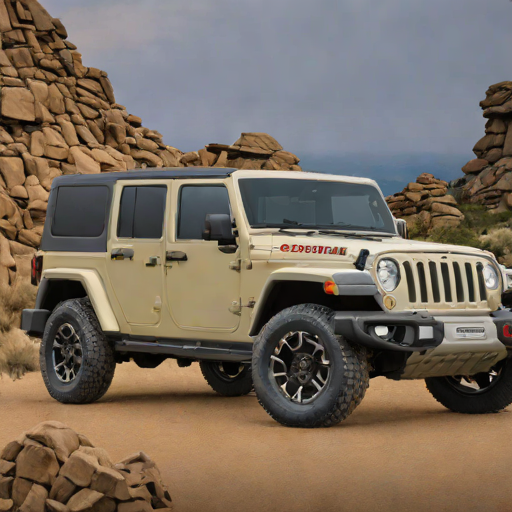

In [25]:
# path of ground truth: /home/ldy/Workspace/THINGS/images_set/test_images
k = 99
image_embeds = emb_img_test[k:k+1]
print("image_embeds", image_embeds.shape)
image = generator.generate(image_embeds)
display(image)

In [26]:
# image_embeds = emb_eeg_test[k:k+1]
# print("image_embeds", image_embeds.shape)
# image = generator.generate(image_embeds)
# display(image)

Generating by eeg informed image embeddings

In [27]:
# k = 0
eeg_embeds = emb_eeg_test[k:k+1]
print("image_embeds", eeg_embeds.shape)
h = pipe.generate(c_embeds=eeg_embeds, num_inference_steps=50, guidance_scale=5.0)
image = generator.generate(h.to(dtype=torch.float16))
display(image)

image_embeds torch.Size([1, 1024])


50it [00:00, 250.24it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB (GPU 2; 23.69 GiB total capacity; 21.97 GiB already allocated; 85.19 MiB free; 23.21 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF